In [2]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import datetime as dt

In [3]:
# Get the stock quote
crypto_currency = 'BTC'  # BTC
against_currency = 'EUR'
data_source ='yahoo'
period = 100

start = dt.datetime(2012, 1, 1)
end = dt.datetime.now()

ticket = f'{crypto_currency}-{against_currency}'

df = web.DataReader(ticket, data_source=data_source, start=start, end=end)

df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-17,9316.917969,9240.340820,9253.401367,9246.486328,1.466026e+10,9246.486328
2019-09-18,9319.454102,8917.574219,9248.524414,9292.973633,1.804724e+10,9292.973633
2019-09-19,9334.069336,9194.604492,9292.886719,9239.483398,1.337076e+10,9239.483398
2019-09-20,9245.341797,9075.292969,9241.304688,9092.541992,1.218296e+10,9092.541992
2019-09-21,9142.628906,9004.768555,9096.534180,9138.951172,1.197878e+10,9138.951172


In [4]:
df.reset_index(inplace = True)
df.set_index(["Date"])
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-09-17,9316.917969,9240.340820,9253.401367,9246.486328,1.466026e+10,9246.486328
1,2019-09-18,9319.454102,8917.574219,9248.524414,9292.973633,1.804724e+10,9292.973633
2,2019-09-19,9334.069336,9194.604492,9292.886719,9239.483398,1.337076e+10,9239.483398
3,2019-09-20,9245.341797,9075.292969,9241.304688,9092.541992,1.218296e+10,9092.541992
4,2019-09-21,9142.628906,9004.768555,9096.534180,9138.951172,1.197878e+10,9138.951172


In [5]:
sma = df['Close'].rolling(window=period).mean()  # Simple moving average (SMA)
std = df['Close'].rolling(window=period).std()  # Standard deviation
df['Upper'] = sma + (std *2)  # Bollinger band
df['Lower'] = sma - (std *2)  # Bollinger band

df['Short'] = df.Close.ewm(span=20, adjust=False).mean()  # Exponential moving average
df['Long'] = df.Close.ewm(span=50, adjust=False).mean()  # Exponential moving average

df['20MA'] = df['Close'].rolling(window=20).mean()  # 20 moving average (20MA)
df['50MA'] = df['Close'].rolling(window=50).mean()  # 50 moving average (50MA)

shortema = df.Close.ewm(span=12, adjust=False).mean()  # Exponential moving average
longema = df.Close.ewm(span=26, adjust=False).mean()  # Exponential moving average
df['MACD'] = shortema - longema  # MACD
df['Signal'] = df.MACD.ewm(span=9, adjust=False).mean()  # Exponential moving average

df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Upper,Lower,Short,Long,20MA,50MA,MACD,Signal
0,2019-09-17,9316.917969,9240.340820,9253.401367,9246.486328,1.466026e+10,9246.486328,NaN,NaN,9246.486328,9246.486328,NaN,NaN,0.000000,0.000000
1,2019-09-18,9319.454102,8917.574219,9248.524414,9292.973633,1.804724e+10,9292.973633,NaN,NaN,9250.913690,9248.309360,NaN,NaN,3.708389,0.741678
2,2019-09-19,9334.069336,9194.604492,9292.886719,9239.483398,1.337076e+10,9239.483398,NaN,NaN,9249.825091,9247.963244,NaN,NaN,2.304534,1.054249
3,2019-09-20,9245.341797,9075.292969,9241.304688,9092.541992,1.218296e+10,9092.541992,NaN,NaN,9234.845748,9241.868293,NaN,NaN,-10.543437,-1.265288
4,2019-09-21,9142.628906,9004.768555,9096.534180,9138.951172,1.197878e+10,9138.951172,NaN,NaN,9225.712932,9237.832327,NaN,NaN,-16.787201,-4.369671


In [6]:
df = df.loc[df.shape[0]-period:]
df.reset_index(inplace = True)
df.head()

,index,Date,High,Low,Open,Close,Volume,Adj Close,Upper,Lower,Short,Long,20MA,50MA,MACD,Signal
0,522,2021-02-25,42492.488281,38735.164062,40847.492188,38735.164062,4.483220e+10,38735.164062,44605.049952,7410.342762,39778.339909,34220.035620,40341.339746,33618.211055,2882.229256,3515.379632
1,523,2021-02-26,40021.406250,36636.480469,38806.402344,38385.910156,2.907271e+11,38385.910156,44868.196940,7614.307943,39645.727551,34383.403249,40631.211621,33744.140312,2429.238451,3298.151396
2,524,2021-02-27,39970.886719,37498.867188,38390.062500,38260.480469,3.803061e+10,38260.480469,45114.789307,7832.609580,39513.799258,34535.445493,40929.803125,33841.904297,2036.641710,3045.849458
3,525,2021-02-28,38697.835938,35819.453125,38265.089844,37332.503906,4.420232e+10,37332.503906,45328.109357,8051.836014,39306.056843,34645.134058,40879.944922,33929.993203,1631.815458,2763.042658
4,526,2021-03-01,41319.687500,37313.160156,37350.476562,41192.191406,4.472789e+10,41192.191406,45673.146502,8216.182150,39485.688707,34901.881405,41021.439648,34124.383320,1603.943004,2531.222728


In [7]:
df.shape

(100, 16)

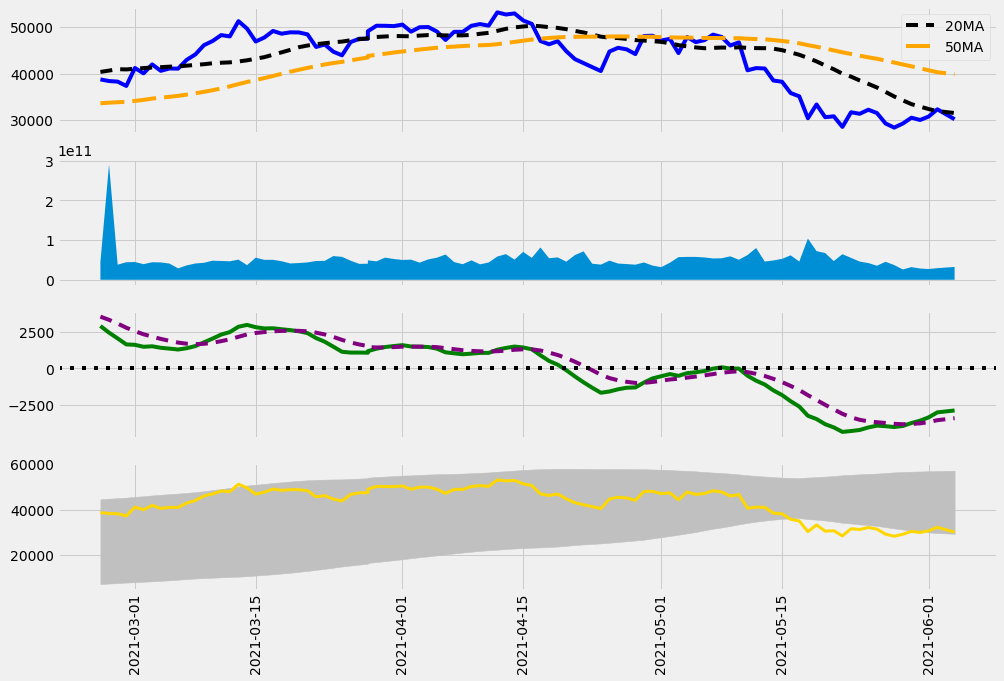

In [86]:
fig, axs = plt.subplots(4, 1, figsize=(15, 10))

axs[0].plot(df['Date'], df['Close'], color='blue')
axs[0].plot(df['Date'], df['20MA'], label='20MA', color='black', dashes=[3, 2])
axs[0].plot(df['Date'], df['50MA'], label='50MA', color='orange', dashes=[6, 2])
axs[0].set(xticklabels=[])
axs[0].grid(True)
axs[0].legend(loc="upper right")

axs[1].fill_between(df['Date'], df['Volume'])
axs[1].set(xticklabels=[])
axs[1].grid(True)

axs[2].plot(df['Date'], df['MACD'], label='MACD', color='green')
axs[2].plot(df['Date'], df['Signal'], label='Signal', color='purple', dashes=[3, 2])
axs[2].axhline(y = 0, color = 'black', dashes=[1, 2])
axs[2].set(xticklabels=[])
axs[2].grid(True)

axs[3].fill_between(df['Date'], df['Upper'], df['Lower'], color='silver')
axs[3].plot(df['Date'], df['Close'], color='gold', lw=3, label='Close Price')
axs[3].tick_params(axis='x', rotation=90)
axs[3].grid(True)

# fig.tight_layout()
plt.show()
